# Structural Imbalance in a Social Network

## Introduction to the problem

> &#128161; This lesson is strongly inspired by the DWave Ocean Tutorial of Structural Imbalance in a Social Network.

**Social networks**: map relationships between people onto graphs. The people are the nodes and their relationships are the edges.

**Signed social networks**: map friendly and hostile relationships by assigning to edges either positive or negative values.

Such networks are said to be *structurally balanced* when they can be divided into two sets, with each set containing only friends, and all relations between these sets are hostile.

The measure of *frustration*, or structural imbalance, for a signed social network is the minimum number of edges that violate the social rule:
> **Social rule:** "The enemy of my friend is my enemy"

Finding a division that minimizes frustration is an NP-hard graph problem (is an expansion of the max-cut problem!).

---
## NetworkX Python library

So first of all, let's see how to work with graphs in python!
The most famous library for this is `networkx`.

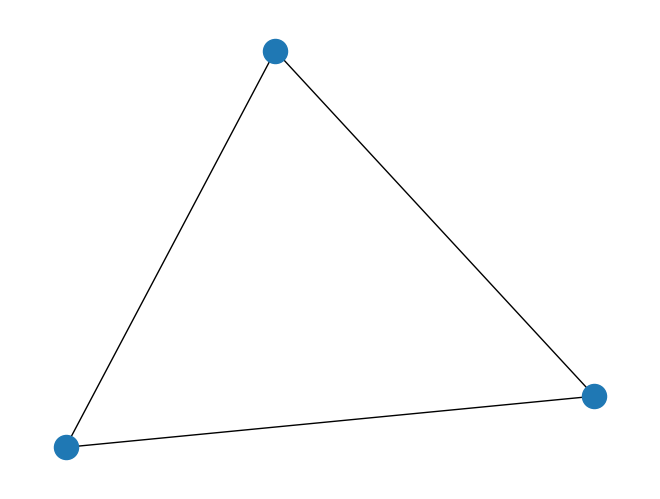

In [8]:
import networkx as nx

G1 = nx.Graph()
G1.add_node(1)
G1.add_node(2)
G1.add_node(3)
G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(3,1)

nx.draw(G1)

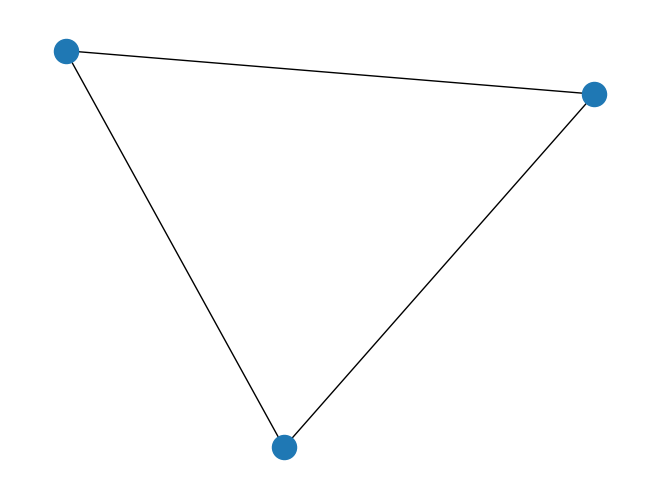

In [9]:
G2 = nx.Graph()
G2.add_edges_from([(1,2), (2,3), (3,1)])
nx.draw(G2)

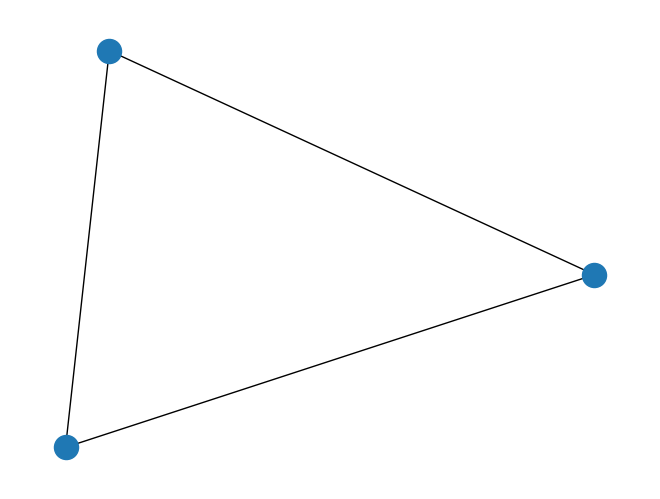

In [10]:
G3 = nx.complete_graph(3)
nx.draw(G3)

Attributes such as weights, labels, colors, or whatever Python object you like, can be attached to graphs, nodes, or edges.

Each graph, node, and edge can hold key/value attribute pairs in an associated attribute dictionary (the keys must be hashable). By default these are empty, but attributes can be added or changed using `add_edge`, `add_node` or direct manipulation of the attribute dictionaries named `G.graph`, `G.nodes`, and `G.edges` for a graph `G`.

{(0, 1): Text(0.5000000000000003, 0.04786555399941256, '5')}

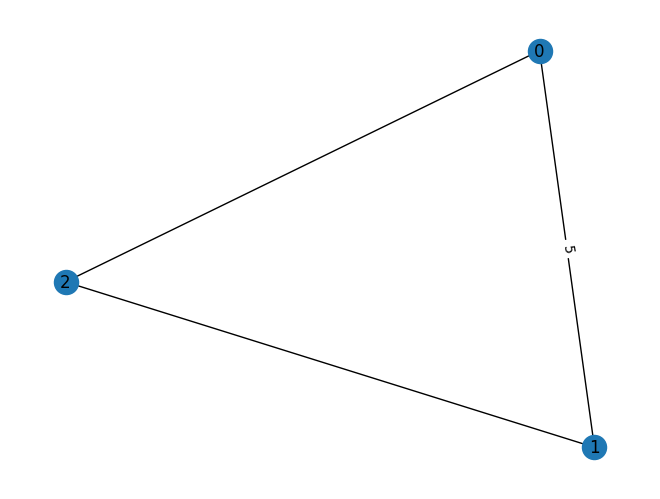

In [11]:
G4 = nx.Graph()
G4.add_edges_from([
    (0,1, {'edge attribute': 'first edge', "attribute 2" : 5}),
    (1,2, {'edge attribute': 'second edge'}),
    (2,0, {'edge attribute': 'third edge'}),
])

pos = nx.spring_layout(G4, seed=0) #there are many layouts
labels = nx.get_edge_attributes(G4, 'attribute 2')

nx.draw(G4, pos, with_labels=True)
nx.draw_networkx_edge_labels(G4, pos, edge_labels=labels)

Now let's switch to Ising model in order to solve the same problem!

---
## Ising Formulation of the signed unbalanced network

Recall what we said last time.

Copy your API token (on the webpage click `COPY`) and paste it in the cell below next to the symbol `>`



In [12]:
# COPY HERE > DEV-434285c76c320541d7dd71d451bd8fb3b4bead07

Make all the necessary imports as explained in `Ising_Problem_AQC.ipynb`.

In [13]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip install dwave-ocean-sdk && dwave config create

In [14]:
from dwave.cloud import Client
with Client.from_config() as client:
  available_solvers = client.get_solvers()

for solver in available_solvers:
  print(solver)

BQMSolver(id='hybrid_binary_quadratic_model_version2')
DQMSolver(id='hybrid_discrete_quadratic_model_version1')
StructuredSolver(id='Advantage_system4.1')
CQMSolver(id='hybrid_constrained_quadratic_model_version1')
StructuredSolver(id='Advantage_system6.4')
StructuredSolver(id='Advantage2_prototype2.3')


In [15]:
from dwave.cloud import Client
with Client.from_config() as client:
  solver = client.get_solver('Advantage_system6.4')   # SELECT THE SOLVER


In this case, variables $s_i$ can represent people, with values $-1,+1$ denoting a person's assignment to one of the two sets you want to divide the social network into. If you set $J_{i,j}$ to $-1$ for friendly $s_is_j$ pairs and $+1$ for hostile pairs, their multiplication takes values

$J_{i,j} s_i s_j=
\begin{cases}
      -1 & \text{friends in same set (} s_i=s_j \text{) or enemies in different sets ($s_i \ne s_j$)} \\
      +1 & \text{friends in different sets ($s_i \ne s_j$) or enemies in same set ($s_i=s_j$)}
\end{cases}
$

The summation $\sum_{i<j}^N J_{i,j} s_i s_j$ now decrements when an assignment contributes to balance and increments when it contributes to frustration.

If you set $h_i=0$, the Ising model is just $\sum_{i<j}^N J_{i,j} s_i s_j$. Programmed with these coefficients for a given signed social network, the quantum computer finds partitions (assignments of $s_i$) that minimize frustration.

##### **Exercise 1**
Write the Ising model associated with the following social network:

Friendly relationships:
-	Alice & Carl
-	Alice & David
- Bob & Carl

Hostile relationships:
-	Alice & Bob
-	Bob & David


In [16]:
h = {}
# REMEMBER
# J range:  [-1.0, 1.0]


## 0 Alice 
## 1 Bob
## 2 Carl
## 3 David
J ={
    (0,2): -1, ## Alice & Carl Frieds
    (0,3): -1, ## Alice & David Frieds
    (1,2): -1, ## Bob adn Carl Friends
    (0,1): 1, ## Alice and Bob Hostiles
    (1,3): 1, ## Bob and David Hostiles
    }

In [17]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler('Advantage_system6.4'))
response = sampler.sample_ising(h,J)
sample = next(iter(response))

In [18]:
print(sample)

{0: -1, 1: 1, 2: 1, 3: -1}


In [22]:
print (response.info)

{'timing': {'qpu_sampling_time': 93.88, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 53.3, 'qpu_access_time': 15875.05, 'qpu_access_overhead_time': 1299.95, 'qpu_programming_time': 15781.17, 'qpu_delay_time_per_sample': 20.58, 'total_post_processing_time': 1.0, 'post_processing_overhead_time': 1.0}, 'problem_id': 'f366e167-c687-430e-a0dd-a21b2df0db88'}


In [23]:
response.record

rec.array([([-1,  1,  1, -1], -3., 1, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')])

## The `SampleSet` class

When you submit a problem to the quantum computer through the `sample_ising` function, the output is a `SampleSet`.

##### **Exercise 2**

Go into the documentation and explore how a `SampleSet` object is structured.

##### **Exercise 3**

Take the output of the previous `sample_ising` and print the sample with the lowest energy.

> &#128161; **Hint!** There is a PROPERTY of a `SampleSet` for that.

In [26]:
response.first

Sample(sample={0: -1, 1: 1, 2: 1, 3: -1}, energy=-3.0, num_occurrences=1, chain_break_fraction=0.0)

---
## Graph formulation and convertion to Ising problem

You can formulate an unbalanced network problem in a graph using `networkx`.

##### **Exercise 4**

Write the GRAPH model associated with the following social network (same as before):

Friendly relationships:
-	Alice & Carl
-	Alice & David
- Bob & Carl

Hostile relationships:
-	Alice & Bob
-	Bob & David

> &#9888;&#65039; **Attention!** Here a bad relationship is associated with a negative sign!

NetworkXError: Node 0 has no position.

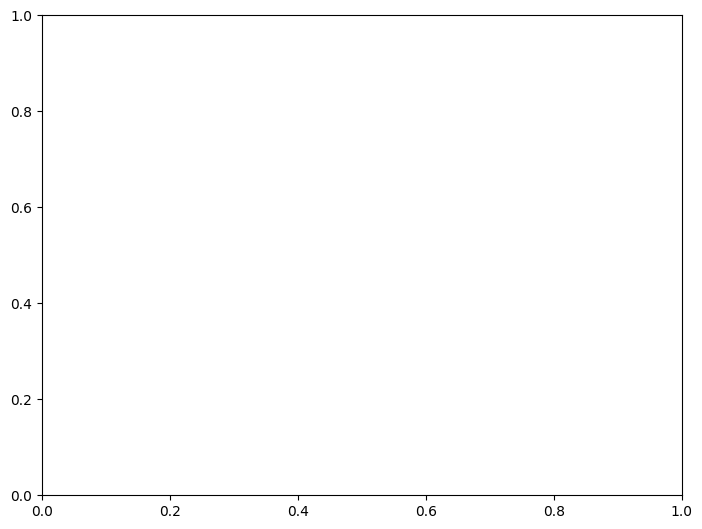

In [38]:
G1 = nx.Graph()
G1.add_edges_from([
    ("Alice","Carl", {"sign" : +1} ),
    ("Alice","David", {"sign" : +1} ),
    ("Bob","Carl", {"sign" : -1}),
    ("Bob","David", {"sign" : -1})])


pos = nx.spring_layout(G1, seed=0) #there are many layouts
labels = nx.get_edge_attributes(G1, 'sign')

nx.draw(G4, pos, with_labels=True)
nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)

Now we need to convert it in an Ising model. The next cell does that for you:

In [ ]:
h = {v: 0 for v in G}

J = {}
for v1, v2, data in G.edges(data=True):
  J[(v1,v2)] = -1 * data['sign']

> &#9888;&#65039; **Attention!** The factor `-1` accounts for the fact that in the Ising model an energy-fevored term has negative net sign.

Now we are able to solve the Ising problem as always:

In [4]:
sampler = EmbeddingComposite(DWaveSampler('Advantage_system6.4'))
response = sampler.sample_ising(h,J)

In [5]:
response.to_pandas_dataframe()

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,-1,1,1,-1,0.0,-3.0,1


## Big Networks

##### **Exercise 5**

Let's make it BIGGER!!
Build a network (graph) of 10 people with random relationships.

In [48]:
import random
import itertools

# make the network

relationship_number = 20
G = nx.Graph()

people = list(range(10))
signs = [ -1, 1]


relations = list(itertools.product(people, people))
random.shuffle(relations)
edges = relations[:relationship_number]

for e in edges:
    e = e + ({"sign" : random.choice(signs)},)

G.add_edges_from(edges)

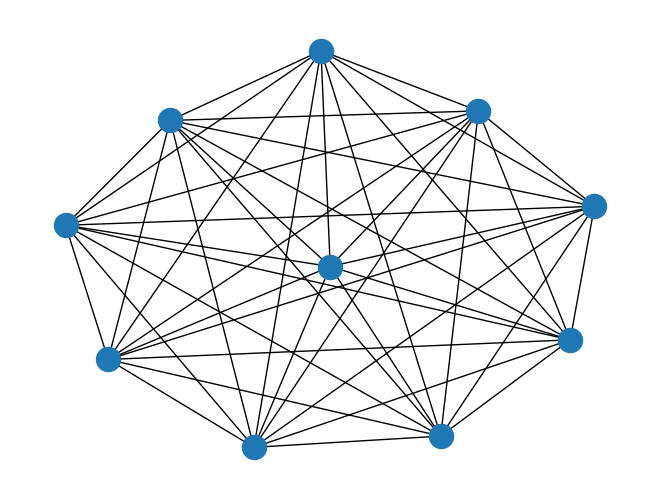

In [56]:
nx.draw(nx.complete_graph(["Alice", "Bob", "Charlie", "Den", "Eve", "Fab", "Geeno", "Hippo", "Iris", "Jimmy"]))

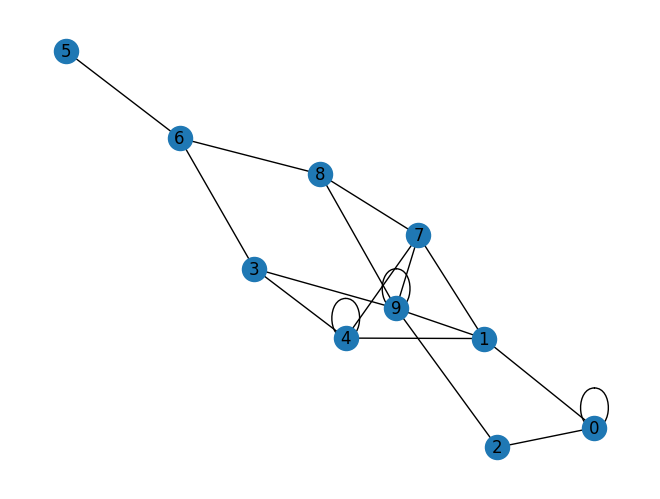

In [51]:
nx.draw(G, with_labels=True)

In [ ]:
# convert it to ising

In [ ]:
# solve it

sampler = EmbeddingComposite(DWaveSampler('Advantage_system6.4'))
response = sampler.sample_ising(h,J)
sample = next(iter(response))

colors = {v: (spin+1)//2 for v, spin in sample.items()}

frustrated_edges = {}

for u, v, data in G.edges(data=True):
    sign = data['sign']

    if sign > 0 and colors[u] != colors[v]:
        frustrated_edges[(u, v)] = data
    elif sign < 0 and colors[u] == colors[v]:
        frustrated_edges[(u, v)] = data
    # else: not frustrated or sign == 0, no relation to violate

In [ ]:
# Mark on the graph the returned frustrated edges and node set (color)
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in frustrated_edges
for node in G.nodes:
    G.nodes[node]['color'] = colors[node]

print('Yellow set: \n\t' + '\n\t'.join(list(person for (person, color) in colors.items() if (color == 0))))
print('Blue set: \n\t' + '\n\t'.join(list(person for (person, color) in colors.items() if (color == 1))))
print('Frustrated relationships: \n\t' + '\n\t'.join(list(x + " & " + y for (x, y) in frustrated_edges.keys())))

Then we can make a fancy drawing of the solution.

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product

edgelist = G.edges()
nodelist = G.nodes()

position = nx.circular_layout(G) # try more fancy layouts

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_facecolor('#202239')
circle_size = 200

edge_color = ['#87DACD' if G[v1][v2]['sign'] == 1 else '#FC9291' for v1,v2 in edgelist]
node_color = ['#4378F8' if nodelist[v]['color'] else '#FFE897' for v in nodelist]
edge_style = ['dashed' if G[u][v]['frustrated'] else 'solid' for u,v in edgelist]

nx.draw_networkx_nodes(G, pos = position, node_color=node_color, node_size=circle_size)
edge_collect = nx.draw_networkx_edges(G, pos = position, edgelist=edgelist, edge_color=edge_color, style=edge_style)

nx.draw_networkx_labels(G, pos=position, font_size=20, font_color='white', horizontalalignment='right', verticalalignment='top')

plt.show()

In [ ]:
edgelist = G.edges()
nodelist = G.nodes()

dist = defaultdict(dict)
for u,v in product(nodelist, repeat=2):
  if u == v:
    dist[u][v] = 0
  elif nodelist[u]['color'] == nodelist[v]['color']:
    dist[u][v] = 1
  else:
    dist[u][v] = 2
position = nx.kamada_kawai_layout(G, dist)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_facecolor('#202239')
circle_size = 200

edge_color = ['#87DACD' if G[v1][v2]['sign'] == 1 else '#FC9291' for v1,v2 in edgelist]
node_color = ['#4378F8' if nodelist[v]['color'] else '#FFE897' for v in nodelist]
edge_style = ['dashed' if G[u][v]['frustrated'] else 'solid' for u,v in edgelist]

nx.draw_networkx_nodes(G, pos = position, node_color=node_color, node_size=circle_size)
edge_collect = nx.draw_networkx_edges(G, pos = position, edgelist=edgelist, edge_color=edge_color, style=edge_style)

nx.draw_networkx_labels(G, pos=position, font_size=20, font_color='white', horizontalalignment='right', verticalalignment='top')

plt.show()

## Embedding Composites

First of all we need to know more about the structure of the qpu: we can ask DWave the
- `target_edgelist`: list containing every edge in the topology
- `target_edjacency`: dictionary containing the list of neighbours for every qubit

In [ ]:
sampler = DWaveSampler() # no embedding composite!

# have a look at the structure of the qpu
__, target_edgelist, target_adjacency = sampler.structure

for key, value in target_adjacency.items():
  print(f"Qubit {key} is connected to\t{value}")


If you want to see the embedding used, a very useful tool is `minorminer`. It finds in an optimal way the best embedding for your model. You can save the embedding with `find_embedding` and then use it into `FixedEmbeddingComposite`.

The difference between `EmbeddingComposite` and `FixedEmbeddingComposite` is that in the latter the embedding is... fixed! So you choose the embedding to use and every time you run the code, the embedding will be the same! On the contrary, when you use `EmbeddingComposite`, every time you run the code the embedding changes. This is unfortunate for scientists who always want their experiments to be reproducible!

In [ ]:
from minorminer import find_embedding
import numpy as np

embedding = find_embedding(J, target_edgelist)
embedding

In [ ]:
from dwave.system.composites import FixedEmbeddingComposite

sampler = DWaveSampler() # no embedding composite!

solver = FixedEmbeddingComposite(sampler, embedding)
N_reads = 100

response = solver.sample_ising(h, J, num_reads=N_reads, return_embedding=True)


In [ ]:
embedding

In [ ]:
response.record

In [ ]:
response.to_pandas_dataframe()

In [ ]:
response.info

## Real world application

In [ ]:
# https://github.com/dwave-examples/structural-imbalance-notebook/blob/master/01-structural-imbalance-overview.ipynb